In [37]:
%load_ext autoreload
%autoreload 2

from importlib import reload
import pathlib
from tqdm import tqdm

import torch
import torch.nn.functional as F
import torchaudio
import numpy as np
import scipy
import s3prl.hub

from wav2avatar.streaming.emformer import emformer as emf
from wav2avatar.utils import utils, nema_data

import wav2avatar.inversion.wav2ema as w2e
import wav2avatar.inversion.linear_inversion as linv

import matplotlib.font_manager
from matplotlib import rc
import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'sans serif'

reload(utils)
from wav2avatar.utils import utils
reload(utils)
from wav2avatar.utils import utils

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
colors = ["indianred", "peru", "goldenrod", "olive", "darkseagreen", "seagreen", "teal", "royalblue", "black"]

In [3]:
# Emformer Import

device = 7
input_dim=512
num_heads=16
ffn_dim=512
num_layers=15
segment_length=5
left_context_length=20
right_context_length=0

emformer = emf.EMAEmformer(
    input_dim=input_dim,
    num_heads=num_heads,
    ffn_dim=ffn_dim,
    num_layers=num_layers,
    segment_length=segment_length,
    left_context_length=left_context_length
).to(device)

ckpt = torch.load(f"emformer/ckpts/emf_l{left_context_length}_r{right_context_length}_p{segment_length}_nh{num_heads}__nl{num_layers}_ffd{ffn_dim}_0.89.pth", map_location="cuda:0")

emformer.load_state_dict(ckpt["emformer_state_dict"])

<All keys matched successfully>

In [4]:
# BiGRU import

bigru = w2e.Wav2EMA(model_dir="../inversion/ckpts/hprc_no_m1f2_h2emaph_gru_joint_nogan_model", gru=True, device=7)
#bigru = w2e.Wav2EMA(model_dir="../inversion/ckpts/hprc_no_m1f2_wlm2tvph_norm_transformer_conv_joint_nogan_v5/", gru=False, mri=False, device=7)

# Linear Inversion import

linv_model = linv.LinearInversion(None, ckpt="../inversion/ckpts/lr_wlm_l9_mng_90_10hz.pkl", device=7)

--- using cuda ---


In [5]:
feature_model = getattr(s3prl.hub, "wavlm_large")()
feature_model = feature_model.model.feature_extractor.to(device)

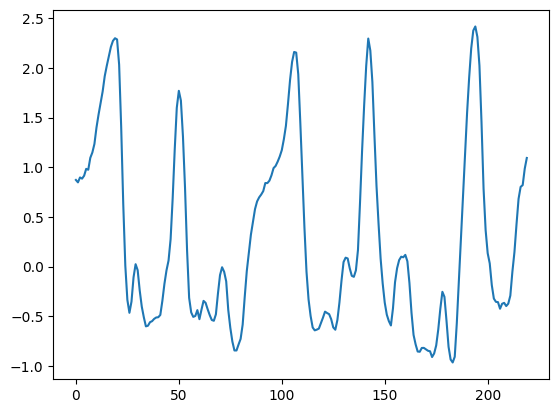

In [294]:
mng_08_audio, sr = torchaudio.load("../inversion/wav/mngu0_s1_0008.wav")
mng_ema_gt = np.load("../inversion/ema/mngu0_s1_0008.npy")
#mng_ema_gt = utils.Utils.mngu0_to_hprc(mng_ema_gt)
mng_ema_gt = linv.EMADataset.butter_bandpass_filter(mng_ema_gt, 10, 50)
mng_ema_gt = linv.EMADataset.downsample_by_mean(mng_ema_gt, 200 // 50)

val_file = "../inversion/wav/mngu0_s1_0729.wav"
mng_val_audio, sr = torchaudio.load(val_file)
mng_ema_gt = np.load("../inversion/ema/mngu0_s1_0729.npy")
#mng_ema_gt = utils.Utils.mngu0_to_hprc(mng_ema_gt)
mng_ema_gt = linv.EMADataset.butter_bandpass_filter(mng_ema_gt, 10, 50)
mng_ema_gt = linv.EMADataset.downsample_by_mean(mng_ema_gt, 200 // 50)
# Sanity Check
plt.plot(mng_ema_gt[:, 0])

In [295]:
mng_08_np = mng_08_audio.squeeze(0).cpu().numpy()
print(mng_08_np.shape)
bigru_full_pred = bigru.wav_to_ema(mng_08_np)[:, :12]

mng_54_np = mng_val_audio.squeeze(0).cpu().numpy()
print(mng_54_np.shape)
bigru_full_pred = bigru.wav_to_ema(mng_54_np)[:, :12]

bigru_full_pred = linv.EMADataset.downsample_by_mean(bigru_full_pred, 100 // 50)

mng_ema_gt_std = np.zeros_like(mng_ema_gt)
for i in range(12):
    bigru_full_pred[:, i] = (bigru_full_pred[:, i] - np.min(bigru_full_pred[:, i]))/(np.max(bigru_full_pred[:, i]) - np.min(bigru_full_pred[:, i]))
    mng_ema_gt_std[:, i] = (mng_ema_gt[:, i] - np.min(mng_ema_gt[:, i]))/(np.max(mng_ema_gt[:, i]) - np.min(mng_ema_gt[:, i]))
#mng_ema_gt_std = (mng_ema_gt - np.min(mng_ema_gt))/(np.max(mng_ema_gt) - np.min(mng_ema_gt))
#bigru_full_pred = np.interp(bigru_full_pred, (bigru_full_pred.min(), bigru_full_pred.max()), (0, 1))


#mng_ema_gt_std = np.interp(mng_ema_gt, (mng_ema_gt.min(), mng_ema_gt.max()), (0, 1))
#

def minmax_normalize(ema):
    for i in range(12):
        ema[:, i] = (ema[:, i] - np.min(ema[:, i]))/(np.max(ema[:, i]) - np.min(ema[:, i]))

linv_full_pred = linv_model.predict_from_tensor(mng_08_audio.squeeze(0).to(device))
print(linv_full_pred.shape)

linv_full_pred = linv_model.predict_from_tensor(mng_val_audio.squeeze(0).to(device))
print(linv_full_pred.shape)

(101702,)
(78182,)
(317, 12)
(244, 12)


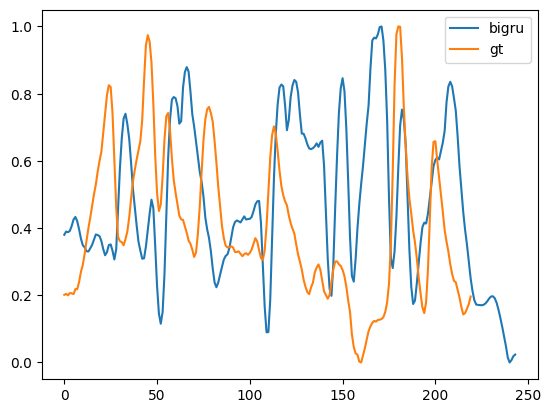

In [74]:
plt.plot(bigru_full_pred[:, 1], label="bigru")
plt.plot(mng_ema_gt_std[:, 1], label="gt")
plt.legend()

PearsonRResult(statistic=0.9184349454726654, pvalue=9.204105028370844e-90)


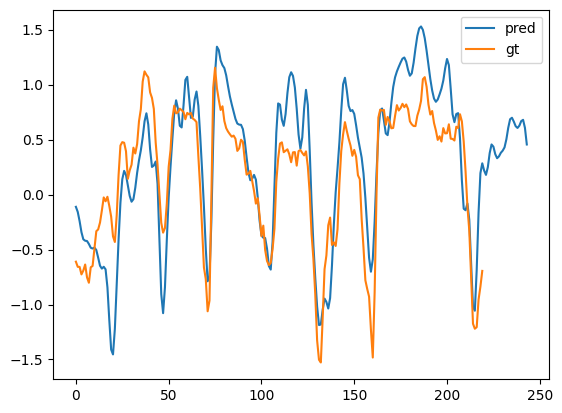

In [75]:
plot_len = min(len(bigru_full_pred), len(mng_ema_gt_std))
plt.plot(linv_full_pred[:, 8], label="pred")
plt.plot(mng_ema_gt[:, 8], label="gt")
print(scipy.stats.pearsonr(linv_full_pred[:plot_len, 0], mng_ema_gt_std[:plot_len, 0]))
plt.legend()

In [394]:
def predict_ema(full_input, state=None):
    x = None
    lengths = torch.zeros(full_input.shape[0],) + 50
    lengths = lengths.to(device)
    input_size = segment_length #+ right_context_length
    for i in range(0, full_input.shape[1], segment_length):
        input_ = full_input[:, i:i+input_size, :]
        if input_.shape[1] < input_size:
            input_ = F.pad(input_, (0, 0, 0, input_size - input_.shape[1]))
        x2, lengths, state = emformer.emformer.infer(input_, lengths, state)
        x2 = emformer.output_layer(x2).squeeze(0)
        if x == None:
            x = x2
        else:
            x = torch.cat([x, x2], dim=0)

    x = x.detach().cpu()
    x = torch.tensor(linv.EMADataset.butter_bandpass_filter(x, 10, 50).copy())
    return x, state

def plot_all_feats(x, mng_ema_gt):
    plt.tight_layout()
    fig, axs = plt.subplots(3, 4, figsize=(20, 10))
    parts = ["tt", "tb", "td", "li", "ul", "ll"]
    feat_num = 0
    corrs = []
    for row in range(3):
        for col in range(4):
            plot_len = min(x.shape[0], mng_ema_gt.shape[0])
            axs[row][col].plot(x[:plot_len, feat_num], label="pred")
            axs[row][col].plot(mng_ema_gt[:plot_len, feat_num], label="gt")
            axs[row][col].legend()
            corr = scipy.stats.pearsonr(x[:plot_len, feat_num], mng_ema_gt[:plot_len, feat_num])
            corrs.append(corr[0])
            part = parts[feat_num // 2]
            xy = "x" if feat_num % 2 == 0 else "y"
            axs[row][col].title.set_text(f"{part} {xy} Correlation: {round(corr[0], 2)}")
            feat_num += 1
    fig.suptitle(f"Emformer vs MNGU0 Ground Truth Correlations, Avg: {round(np.mean(corrs), 3)}")

def predict_audio(file, forward=0, predict_ema=predict_ema):
    audio, sr = torchaudio.load(file)
    if audio.shape[0] > 1:
        audio = audio[0].unsqueeze(0)
    audio = torchaudio.functional.resample(
        audio, orig_freq=sr, new_freq=16000
    )
    audio = audio.to(device)
    #audio = torch.cat([audio[:, -8000:], audio], dim=1)

    feats = []
    state = None
    for i in range(0, audio.shape[1], 1600):
        curr_audio = audio[:, i:i+1600+forward]
        if curr_audio.shape[1] < 1600 + forward:
            curr_audio = F.pad(curr_audio, (0, 1600 - curr_audio.shape[1] + forward))
        #print(curr_audio.shape)
        feat = feature_model(curr_audio)
        feat = feat.transpose(1, 2)
        ema, state = predict_ema(feat, state)
        feats.append(ema[:5, :])
    feat = torch.cat(feats, dim=0)
    return feat

def predict_audio_linv(file, forward=0, left_lim=False):
    audio, sr = torchaudio.load(file)
    if audio.shape[0] > 1:
        audio = audio[0].unsqueeze(0)
    audio = torchaudio.functional.resample(
        audio, orig_freq=sr, new_freq=16000
    )
    audio = audio.to(device)
    #audio = torch.cat([audio[:, -32000:], audio], dim=1)

    feats = []
    for i in range(0, audio.shape[1], 1600):
        if left_lim:
            start = i - 8000 if i - 8000 > 0 else i
        else:
            start = 0
        curr_audio = audio[:, start:i+1600+forward]
        ema = linv_model.predict_from_tensor(curr_audio.squeeze(0))

        right_context_samples = forward // 320

        if i + 1600 + forward >= audio.shape[1]:
            ema = ema[-(right_context_samples + 5):, :]
        else:
            ema = ema[-(right_context_samples + 5):-right_context_samples or None, :]
        feats.append(linv.EMADataset.butter_bandpass_filter(ema, 10, 50))

    feat = np.concatenate(feats, axis=0)
    #feat = linv.EMADataset.butter_bandpass_filter(feat, 10, 50)
    return feat

def predict_audio_bigru(file, forward=0):
    audio, sr = torchaudio.load(file)
    if audio.shape[0] > 1:
        audio = audio[0].unsqueeze(0)
    audio = torchaudio.functional.resample(
        audio, orig_freq=sr, new_freq=16000
    )
    audio = audio.to(device)
    #audio = torch.cat([audio[:, -8000:], audio], dim=1)

    feats = []
    #for i in range(8000, audio.shape[1], 1600):
    #    curr_audio = audio[:, i-8000:i+1600+forward]
    #    ema = bigru.wav_to_ema(curr_audio.squeeze(0))
    #    #print(ema.shape)
    #    feats.append(ema[50:60, :])
    for i in range(0, audio.shape[1], 1600):
        start = 0
        curr_audio = audio[:, start:i+1600+forward]
        ema = bigru.wav_to_ema(curr_audio.squeeze(0))

        right_context_samples = forward // 160

        if i + 1600 + forward >= audio.shape[1]:
            ema = ema[-(right_context_samples + 10):, :]
        else:
            ema = ema[-(right_context_samples + 10):-right_context_samples or None, :]
        feats.append(linv.EMADataset.butter_bandpass_filter(ema, 10, 50))
    feat = np.concatenate(feats, axis=0)
    feat = linv.EMADataset.downsample_by_mean(feat, 100 // 50)
    #feat = utils.Utils.mngu0_to_hprc(feat)
    minmax_normalize(feat)
    return feat

In [11]:
# Assume 1600 samples - want to find number of WavLM samples
test_ema = linv_model.predict_from_tensor(mng_08_audio.squeeze(0)[:(1600 + 320)].to(device))
right_context_samples = 320 // 320
print(right_context_samples)
test_ema[-(right_context_samples + 5):-right_context_samples, :].shape

1


(4, 12)

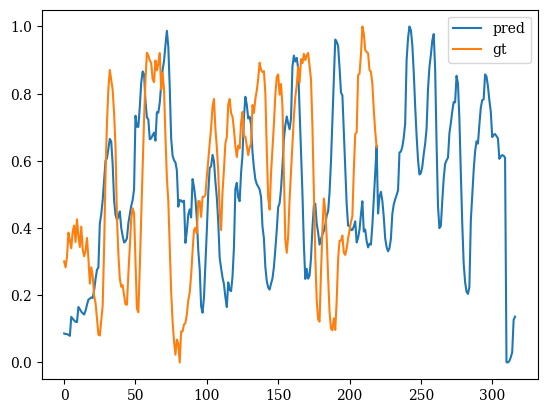

In [12]:
plt.plot(predict_audio_bigru("../inversion/wav/mngu0_s1_0008.wav", forward=2560)[:, 0], label="pred")
plt.plot(mng_ema_gt_std[:, 0], label="gt")
plt.legend()

In [77]:
preds = []
#forwards = [0, 320, 640, 1280, 2560]
#forwards = np.geomspace(320, 20480, 7).astype(int)
#forwards = np.insert(forwards, 0, 0)
forwards = [0, 320, 1280, 16000]

for i in range(len(forwards)):
    print(forwards[i])
    preds.append(predict_audio(val_file, forward=forwards[i]))

0
320
1280
16000


<Figure size 640x480 with 0 Axes>

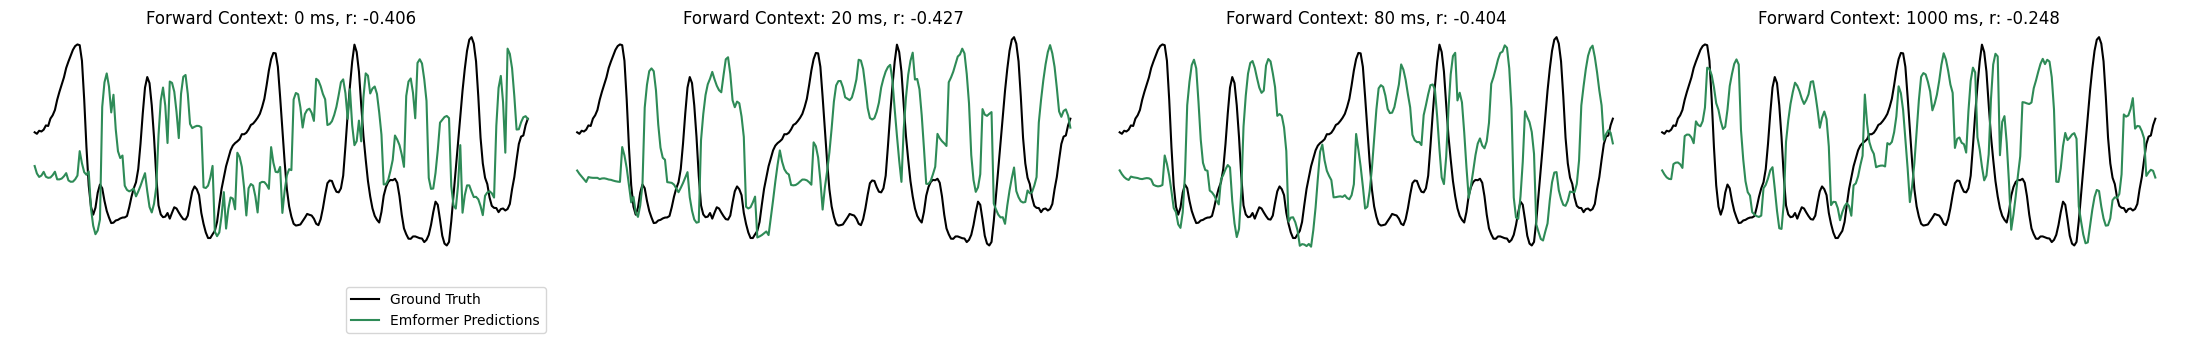

In [113]:
emformer_corrs = []
plt.tight_layout()
fig, axs = plt.subplots(1, len(forwards), figsize=(7 * len(forwards), 4))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(len(forwards)):
    axs[i].axis('off')
    plot_len = min(preds[i].shape[0], mng_ema_gt.shape[0])
    axs[i].plot(mng_ema_gt[:plot_len, 0], label="Ground Truth", color="black")
    axs[i].plot(preds[i][:plot_len, 0], label="Emformer Predictions", color=colors[5])
    axs[i].set_yticklabels([])
    axs[i].set_yticks([])
    axs[i].set_ylim(-2.5, 2.5)
    corr = scipy.stats.pearsonr(preds[i][:plot_len, 0], mng_ema_gt[:plot_len, 0])
    axs[i].set_title(f"Forward Context: {round(forwards[i] / 16000 * 1000)} ms, r: {round(corr[0], 3)}")
axs[0].legend(loc="lower right")

In [79]:
linear_preds = []
#forwards = [0, 320, 640, 1280, 2560]

for i in range(len(forwards)):
    print(forwards[i])
    linear_preds.append(predict_audio_linv(val_file, forward=forwards[i]))

0
320
1280
16000


In [395]:
bigru_preds = []

for i in range(len(forwards)):
    print(forwards[i])
    bigru_preds.append(predict_audio_bigru(val_file, forward=forwards[i]))

0
320
1280
16000


In [214]:
linear_preds = [utils.Utils.mngu0_to_hprc(pred) for pred in linear_preds]

<Figure size 640x480 with 0 Axes>

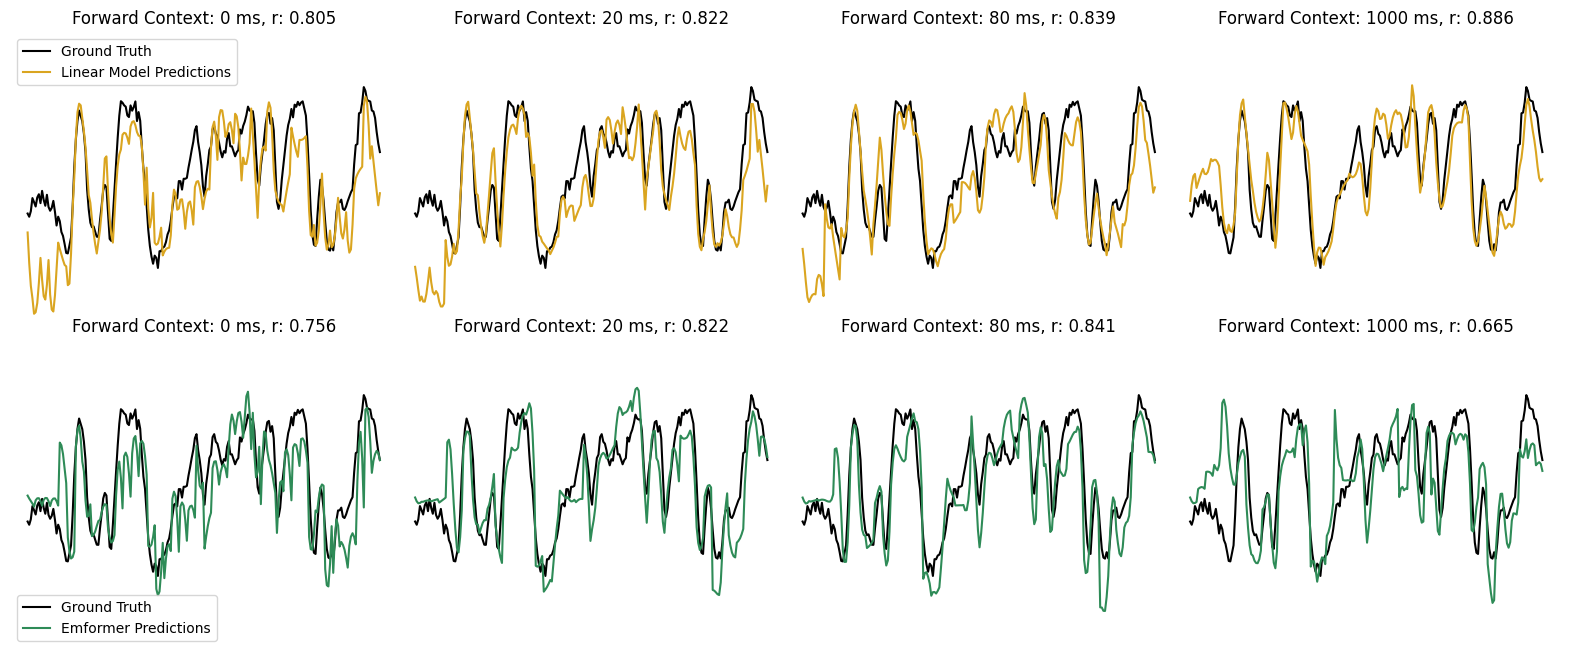

In [396]:
plt.tight_layout()
feat = 0
linear_corrs = []
fig, axs = plt.subplots(2, len(forwards), figsize=(5 * len(forwards), 8))
plt.subplots_adjust(wspace=0, hspace=0)

#mng_ema_gt = utils.Utils.mngu0_to_hprc(mng_ema_gt)
for i in range(len(forwards)):
    axs[0][i].axis('off')
    plot_len = min(linear_preds[i].shape[0], mng_ema_gt.shape[0])
    axs[0][i].plot(mng_ema_gt[:plot_len, feat], label="Ground Truth", color="black")
    axs[0][i].plot(linear_preds[i][:plot_len, feat], label="Linear Model Predictions", color=colors[2])
    axs[0][i].set_yticklabels([])
    axs[0][i].set_yticks([])
    axs[0][i].set_ylim(-2.5, 2.5)
    corr = scipy.stats.pearsonr(linear_preds[i][:plot_len, feat], mng_ema_gt[:plot_len, feat])
    linear_corrs.append(corr[0])
    axs[0][i].set_title(f"Forward Context: {round(forwards[i] / 16000 * 1000)} ms, r: {round(corr[0], 3)}")

emformer_corrs = []
for i in range(len(forwards)):
    axs[1][i].axis('off')
    plot_len = min(300, min(emformer_preds[i].shape[0], mng_ema_gt.shape[0]))
    axs[1][i].plot(mng_ema_gt[:plot_len, feat], label="Ground Truth", color="black")
    axs[1][i].plot(emformer_preds[i][:plot_len, feat], label="Emformer Predictions", color=colors[5])
    axs[1][i].set_yticklabels([])
    axs[1][i].set_yticks([])
    axs[1][i].set_ylim(-2.5, 2.5)
    corr = scipy.stats.pearsonr(emformer_preds[i][:plot_len, feat], mng_ema_gt[:plot_len, feat])
    emformer_corrs.append(corr[0])
    axs[1][i].set_title(f"Forward Context: {round(forwards[i] / 16000 * 1000)} ms, r: {round(corr[0], 3)}")

axs[0][0].legend(loc="upper left")
axs[1][0].legend(loc="lower left")

fig.savefig("paper_figures/linear_rctxt_vary.pdf", bbox_inches="tight", dpi=300)

In [297]:
mngu0_to_hprc(mng_ema_gt_std)
mng_ema_gt = utils.Utils.mngu0_to_hprc(mng_ema_gt)

In [289]:
emformer_preds = [utils.Utils.mngu0_to_hprc(pred) for pred in preds]

<Figure size 640x480 with 0 Axes>

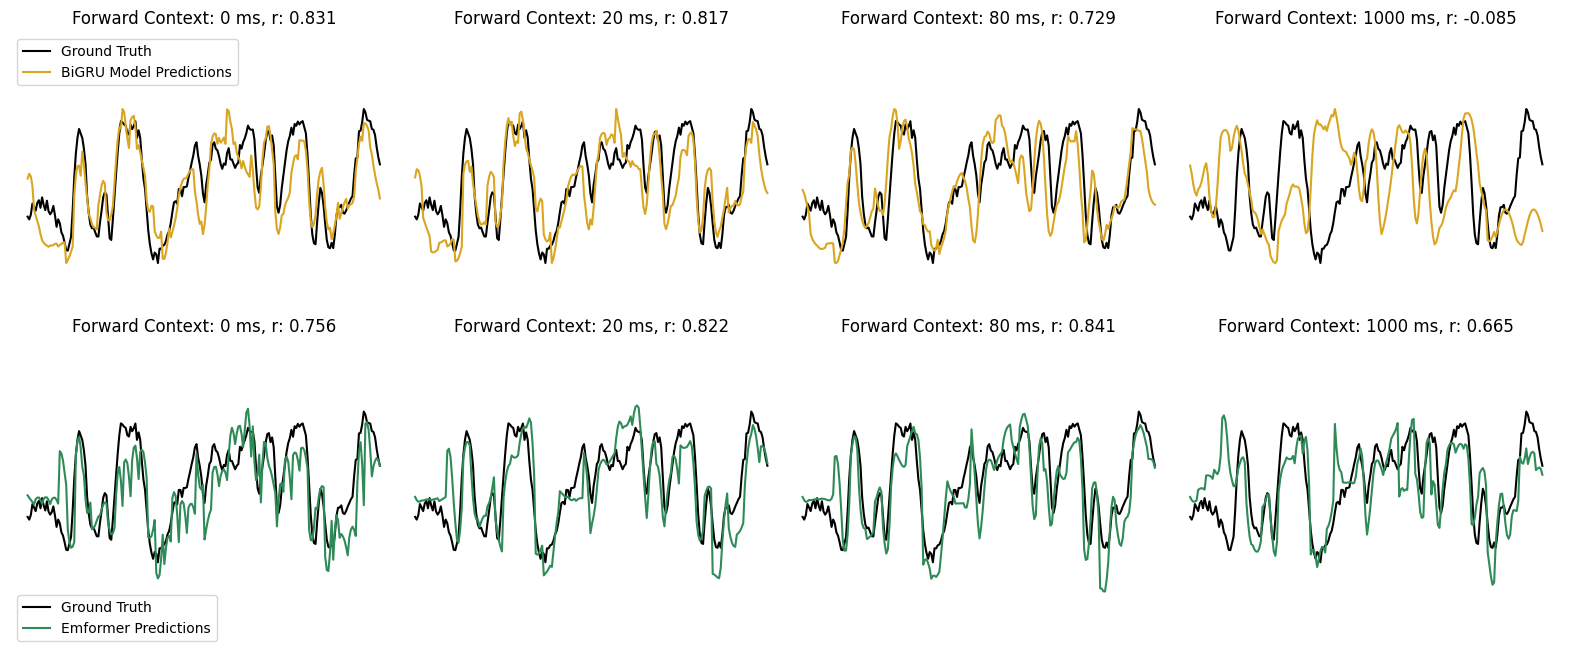

In [393]:
plt.tight_layout()
feat = 0
bigru_corrs = []
fig, axs = plt.subplots(2, len(forwards), figsize=(5 * len(forwards), 8))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(len(forwards)):
    axs[0][i].axis('off')
    plot_len = min(bigru_preds[i].shape[0], mng_ema_gt.shape[0])
    axs[0][i].plot(mng_ema_gt_std[:plot_len, feat], label="Ground Truth", color="black")
    axs[0][i].plot(bigru_preds[i][:plot_len, feat] - 1, label="BiGRU Model Predictions", color=colors[2])



    axs[0][i].set_yticklabels([])
    axs[0][i].set_yticks([])
    axs[0][i].set_ylim(-1.5, 0.5)
    corr = scipy.stats.pearsonr(bigru_preds[i][:plot_len, feat], mng_ema_gt_std[:plot_len, feat])
    bigru_corrs.append(corr[0])
    axs[0][i].set_title(f"Forward Context: {round(forwards[i] / 16000 * 1000)} ms, r: {round(corr[0], 3)}")

emformer_corrs = []
for i in range(len(forwards)):
    axs[1][i].axis('off')
    plot_len = min(300, min(emformer_preds[i].shape[0], mng_ema_gt.shape[0]))
    axs[1][i].plot(mng_ema_gt[:plot_len, feat], label="Ground Truth", color="black")
    axs[1][i].plot(emformer_preds[i][:plot_len, feat], label="Emformer Predictions", color=colors[5])
    axs[1][i].set_yticklabels([])
    axs[1][i].set_yticks([])
    axs[1][i].set_ylim(-3, 3)
    corr = scipy.stats.pearsonr(emformer_preds[i][:plot_len, feat], mng_ema_gt[:plot_len, feat])
    emformer_corrs.append(corr[0])
    axs[1][i].set_title(f"Forward Context: {round(forwards[i] / 16000 * 1000)} ms, r: {round(corr[0], 3)}")

axs[0][0].legend(loc="upper left")
axs[1][0].legend(loc="lower left")

fig.savefig("paper_figures/bigru_rctxt_vary.pdf", bbox_inches="tight", dpi=300)

In [23]:
emformer_corrs = emformer_corrs[:4]
linear_corrs = linear_corrs[:4]
print(emformer_corrs)

[0.7982759809922767, 0.8748087330396107, 0.8768320534847667, 0.6727188102192195]


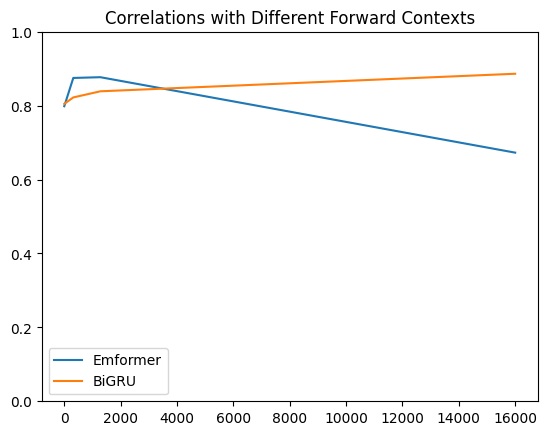

In [24]:
plt.plot(forwards, emformer_corrs, label="Emformer")
plt.plot(forwards, linear_corrs, label="BiGRU")
plt.ylim(0, 1)
plt.title("Correlations with Different Forward Contexts")
plt.legend()

0
320
1280
16000


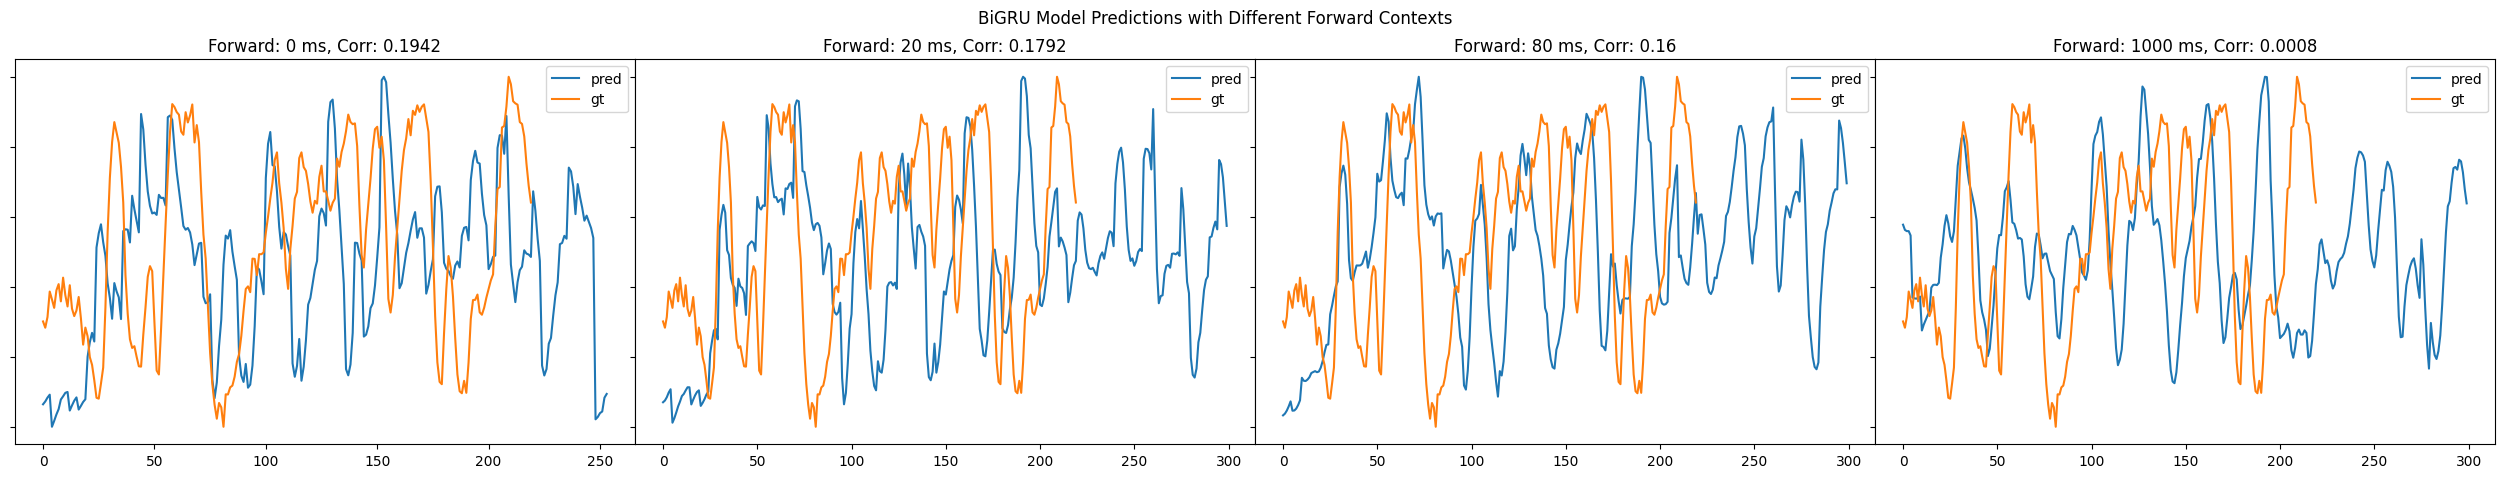

In [25]:
fig, axs = plt.subplots(1, len(forwards), figsize=(8 * len(forwards), 5))
plt.subplots_adjust(wspace=0, hspace=0)
preds = []
#forwards = [0, 320, 640, 1280, 2560]

linear_corrs = []
for i in range(len(forwards)):
    print(forwards[i])
    fig.suptitle("BiGRU Model Predictions with Different Forward Contexts")
    preds.append(predict_audio_bigru("../inversion/wav/mngu0_s1_0008.wav", forward=forwards[i]))
    axs[i].plot(preds[i][:300, 0], label="pred")
    axs[i].plot(mng_ema_gt_std[:300, 0], label="gt")
    plot_len = min(preds[i].shape[0], mng_ema_gt_std.shape[0])
    corr = scipy.stats.pearsonr(preds[i][:plot_len, 0], mng_ema_gt[:plot_len, 0])
    linear_corrs.append(corr[0])
    axs[i].set_title(f"Forward: {round(forwards[i] / 16000 * 1000)} ms, Corr: {round(corr[0], 4)}")
    axs[i].set_yticklabels([])
    axs[i].legend()
plt.show()

MNGU0 Correlations

In [28]:
mngu0_root = pathlib.Path("/data/prabhune/mngu0/mngu0/")

with open(mngu0_root / "split" / "test.txt", "r") as f:
    lines = f.readlines()
lines = [line[:-1] for line in lines]

In [186]:
forward = 320

def mngu0_to_hprc(arr):
    arr_td = arr[:, 0:2]

    arr_tb = arr[:, 2:4]

    arr_tt = arr[:, 4:6]

    arr_li = arr[:, 6:8] # locked

    arr_ul = arr[:, 8:10] # locked

    arr_ll = arr[:, 10:12] # locked

    arr[:, 0] = arr_li[:, 0] * -1
    arr[:, 1] = arr_li[:, 1]
    arr[:, 2] = arr_ul[:, 0] * -1
    arr[:, 3] = arr_ul[:, 1]
    arr[:, 4] = arr_ll[:, 0] * -1
    arr[:, 5] = arr_ll[:, 1]
    arr[:, 6] = arr_tt[:, 0] * -1
    arr[:, 7] = arr_tt[:, 1]
    arr[:, 8] = arr_tb[:, 0] * -1
    arr[:, 9] = arr_tb[:, 1]
    arr[:, 10] = arr_td[:, 0] * -1
    arr[:, 11] = arr_td[:, 1]

emf_mngu0_corrs_forwards = []

for i, forward in enumerate(forwards):
    emf_mngu0_corrs = []
    line_tqdm = tqdm(lines)
    for line in line_tqdm:
        file = mngu0_root / "wav" / f"{line}.wav"
        ema_file = mngu0_root / "ema" / f"{line}.npy"

        gt_ema = np.load(ema_file)
        #gt_ema = utils.Utils.mngu0_to_hprc(gt_ema)
        mngu0_to_hprc(gt_ema)
        gt_ema = linv.EMADataset.butter_bandpass_filter(gt_ema, 10, 50)
        gt_ema = linv.EMADataset.downsample_by_mean(gt_ema, 200 // 50)


        pred_ema = predict_audio(file, forward=forward)
        pred_ema = utils.Utils.mngu0_to_hprc(pred_ema)
        feat = 8

        plot_len = min(pred_ema.shape[0], gt_ema.shape[0])

        feat_corrs = []
        for i in range(12):
            corr = scipy.stats.pearsonr(pred_ema[:plot_len, i], gt_ema[:plot_len, i])
            feat_corrs.append(corr[0])

        feat_mean = np.mean(feat_corrs)
        line_tqdm.set_postfix(corr=feat_mean)
        emf_mngu0_corrs.append(feat_mean)
    
    emf_mngu0_corrs_forwards.append(emf_mngu0_corrs)

100%|██████████| 119/119 [10:50<00:00,  5.47s/it, corr=0.624]


In [189]:
lin_mngu0_corrs_forwards = []

for i, forward in enumerate(forwards):
    lin_mngu0_corrs = []
    line_tqdm = tqdm(lines)
    for line in line_tqdm:
        file = mngu0_root / "wav" / f"{line}.wav"
        ema_file = mngu0_root / "ema" / f"{line}.npy"

        gt_ema = np.load(ema_file)
        #gt_ema = utils.Utils.mngu0_to_hprc(gt_ema)
        #mngu0_to_hprc(gt_ema)
        gt_ema = linv.EMADataset.butter_bandpass_filter(gt_ema, 10, 50)
        gt_ema = linv.EMADataset.downsample_by_mean(gt_ema, 200 // 50)


        pred_ema = predict_audio_linv(file, forward=forward)
        #pred_ema = utils.Utils.mngu0_to_hprc(pred_ema)
        feat = 8

        plot_len = min(pred_ema.shape[0], gt_ema.shape[0])

        feat_corrs = []
        for i in range(12):
            corr = scipy.stats.pearsonr(pred_ema[:plot_len, i], gt_ema[:plot_len, i])
            feat_corrs.append(corr[0])

        feat_mean = np.mean(feat_corrs)
        line_tqdm.set_postfix(corr=feat_mean)
        lin_mngu0_corrs.append(feat_mean)
    lin_mngu0_corrs_forwards.append(lin_mngu0_corrs)

100%|██████████| 119/119 [01:58<00:00,  1.00it/s, corr=0.813]


In [275]:
lin_mngu0_corrs_forwards_win = []

for i, forward in enumerate(forwards):
    lin_mngu0_corrs = []
    line_tqdm = tqdm(lines)
    for line in line_tqdm:
        file = mngu0_root / "wav" / f"{line}.wav"
        ema_file = mngu0_root / "ema" / f"{line}.npy"

        gt_ema = np.load(ema_file)
        #gt_ema = utils.Utils.mngu0_to_hprc(gt_ema)
        #mngu0_to_hprc(gt_ema)
        gt_ema = linv.EMADataset.butter_bandpass_filter(gt_ema, 10, 50)
        gt_ema = linv.EMADataset.downsample_by_mean(gt_ema, 200 // 50)


        pred_ema = predict_audio_linv(file, forward=forward, left_lim=True)

        plot_len = min(pred_ema.shape[0], gt_ema.shape[0])
        #feat = 1
        #plt.plot(pred_ema[:plot_len - 5, feat], label="pred")
        #plt.plot(gt_ema[5:plot_len, feat], label="gt")

        feat_corrs = []
        for i in range(12):
            corr = scipy.stats.pearsonr(pred_ema[:plot_len - 5, i], gt_ema[5:plot_len, i])
            feat_corrs.append(corr[0])

        feat_mean = np.mean(feat_corrs)
        line_tqdm.set_postfix(corr=feat_mean)
        lin_mngu0_corrs.append(feat_mean)
    lin_mngu0_corrs_forwards_win.append(lin_mngu0_corrs)

  0%|          | 0/119 [00:00<?, ?it/s]

100%|██████████| 119/119 [01:48<00:00,  1.10it/s, corr=0.803]


In [ ]:
bgru_mngu0_corrs_forwards = []

for i, forward in enumerate(forwards):
    lin_mngu0_corrs = []
    line_tqdm = tqdm(lines)
    for line in line_tqdm:
        file = mngu0_root / "wav" / f"{line}.wav"
        ema_file = mngu0_root / "ema" / f"{line}.npy"

        gt_ema = np.load(ema_file)
        gt_ema = utils.Utils.mngu0_to_hprc(gt_ema)
        #mngu0_to_hprc(gt_ema)
        minmax_normalize(gt_ema)
        gt_ema = linv.EMADataset.butter_bandpass_filter(gt_ema, 10, 50)
        gt_ema = linv.EMADataset.downsample_by_mean(gt_ema, 200 // 50)


        pred_ema = predict_audio_bigru(file, forward=forward)

        plot_len = min(pred_ema.shape[0], gt_ema.shape[0])
        feat = 8
        plt.plot(pred_ema[:plot_len, feat], label="pred")
        plt.plot(gt_ema[:plot_len, feat], label="gt")
        plt.legend()

        feat_corrs = []
        for i in range(12):
            corr = scipy.stats.pearsonr(pred_ema[:plot_len, i], gt_ema[:plot_len, i])
            feat_corrs.append(corr[0])

        feat_mean = np.mean(feat_corrs)
        line_tqdm.set_postfix(corr=feat_mean)
        lin_mngu0_corrs.append(feat_mean)
    bgru_mngu0_corrs_forwards.append(lin_mngu0_corrs)

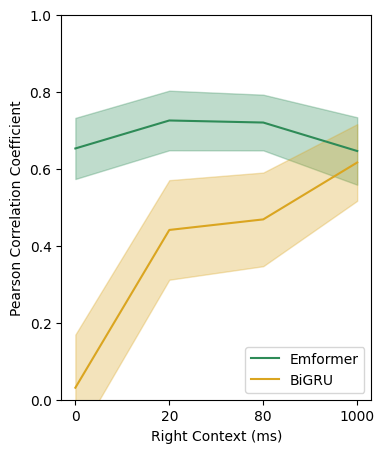

In [364]:
emf_means = [np.mean(corrs) for corrs in emf_mngu0_corrs_forwards]
emf_stds = [np.std(corrs) for corrs in emf_mngu0_corrs_forwards]

lin_means = [np.mean(corrs) for corrs in lin_mngu0_corrs_forwards]
lin_stds = [np.std(corrs) for corrs in lin_mngu0_corrs_forwards]

lin_win_means = [np.mean(corrs) for corrs in lin_mngu0_corrs_forwards_win]
lin_win_stds = [np.std(corrs) for corrs in lin_mngu0_corrs_forwards_win]

bgru_means = [np.mean(corrs) for corrs in bgru_mngu0_corrs_forwards]
bgru_stds = [np.std(corrs) for corrs in bgru_mngu0_corrs_forwards]

emf_mngu0_corrs_forwards_c = emf_mngu0_corrs_forwards.copy()
lin_mngu0_corrs_forwards_c = lin_mngu0_corrs_forwards.copy()
lin_mngu0_corrs_forwards_win_c = lin_mngu0_corrs_forwards_win.copy()
bgru_mngu0_corrs_forwards_c = bgru_mngu0_corrs_forwards.copy()

ms_forwards = list(np.array(forwards) // 16000 * 1000)

fig, ax = plt.subplots(figsize=(4, 5))
ax.plot(emf_means, label="Emformer", color=colors[5])
ax.plot(bgru_means, label="BiGRU", color=colors[2])
#ax.plot(lin_win_means, label="Linear Model (500ms Left Context)", color=colors[1])
ax.set_ylabel("Pearson Correlation Coefficient")
ax.set_xlabel("Right Context (ms)")
ax.set_xticks(range(len(forwards)))
ax.set_xticklabels([0, 20, 80, 1000])
plt.ylim(0, 1)
plt.fill_between(range(len(forwards)), np.array(emf_means) - np.array(emf_stds), np.array(emf_means) + np.array(emf_stds), alpha=0.3, color=colors[5])
#plt.fill_between(range(len(forwards)), np.array(lin_means) - np.array(lin_stds), np.array(lin_means) + np.array(lin_stds), alpha=0.3, color=colors[2])
#plt.fill_between(range(len(forwards)), np.array(lin_win_means) - np.array(lin_win_stds), np.array(lin_win_means) + np.array(lin_win_stds), alpha=0.3, color=colors[1])
plt.fill_between(range(len(forwards)), np.array(bgru_means) - np.array(bgru_stds), np.array(bgru_means) + np.array(bgru_stds), alpha=0.3, color=colors[2])
plt.legend(loc="lower right")

In [249]:
emf_stds

[0.0793543258258932,
 0.07740563024044934,
 0.07228852655901583,
 0.08758952394242775]

In [250]:
lin_stds

[0.10139158277441836,
 0.10125687374887656,
 0.08958918781090557,
 0.08639275714989496]

In [141]:
audio = torchaudio.load(val_file)[0].to(device)
feats = feature_model(audio).to(device)
print(feats.shape)
feats = feats.transpose(1, 2)
pred_ema_emf = predict_ema(feats)[0]

torch.Size([1, 512, 244])


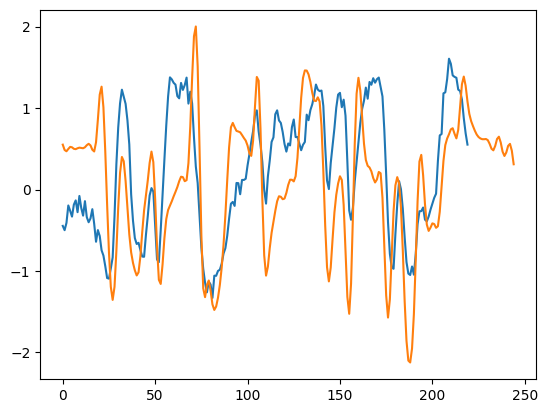

In [171]:
mng = utils.Utils.mngu0_to_hprc(mng_ema_gt)

plt.plot(mng[:, 0])

plt.plot(pred_ema_emf[:, 7])